# 1. Import pakietów i przygotowanie danych

In [1]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import openml
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV

In [2]:
data_1 = openml.datasets.get_dataset(44)
data_2 = openml.datasets.get_dataset(37)
data_3 = openml.datasets.get_dataset(1489)
data_4 = openml.datasets.get_dataset(1116)

dataset_1, y1, _, _ = data_1.get_data(dataset_format="dataframe")
dataset_2, y2, _, _ = data_2.get_data(dataset_format="dataframe")
dataset_3, y3, _, _ = data_3.get_data(dataset_format="dataframe")
dataset_4, y4, _, _ = data_4.get_data(dataset_format="dataframe")

In [3]:
y_1 = dataset_1["class"]
X_1 = dataset_1.drop("class", axis=1, inplace=False)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=123)

dataset_2["class"] = np.where(dataset_2["class"] == "tested_positive", 1, 0)
y_2 = dataset_2["class"]
X_2 = dataset_2.drop("class", axis=1, inplace=False)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=123)

y_3 = dataset_3["Class"]
X_3 = dataset_3.drop(["Class"], axis=1, inplace=False)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=123)

y_4 = dataset_4["class"]
X_4 = dataset_4.drop(["class", "molecule_name"], axis=1, inplace=False)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.2, random_state=123)

training_set_list = [(X_train_1, y_train_1), (X_train_2, y_train_2), (X_train_3, y_train_3), (X_train_4, y_train_4)]
testing_set_list = [(X_test_1, y_test_1), (X_test_2, y_test_2), (X_test_3, y_test_3), (X_test_4, y_test_4)]

# 2. Przygotowanie modeli

In [4]:
num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median'))])

cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore')),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

col_trans = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include=['category','object']))
],remainder='passthrough')

## 2.1 ElasticNet

In [5]:
model_pipeline_en = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('elasticnet', LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=5000))
])

## 2.2 Extra Trees Classifier

In [6]:
model_pipeline_et = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('extra-trees', ExtraTreesClassifier())
])

## 2.3 K-nearest Neighbors Classifier

In [7]:
model_pipeline_knn = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('KNN', KNeighborsClassifier())
])

# 3.Optymalizacja RandomSearch

## 3.1 ElasticNet

In [ ]:
param_grid_en = {S
    'elasticnet__C': np.logspace(10, -10, 300, base=2),
    'elasticnet__l1_ratio': np.linspace(0, 1, 1000),
}

In [39]:
random_en = RandomizedSearchCV(estimator = model_pipeline_en, param_distributions = param_grid_en, n_iter = 1000, cv = 5, random_state=123, n_jobs = -1,scoring='roc_auc', verbose=2)

In [40]:
summary_table_en = pd.DataFrame()
for i in range(len(training_set_list)):
    rand_pred = random_en.fit(training_set_list[i][0], training_set_list[i][1])
    results = pd.DataFrame(rand_pred.cv_results_)
    results_sorted = results.sort_values(by='rank_test_score', ascending=True)

    dataset_id = i+1
    current_results = results[['params', 'mean_test_score', 'rank_test_score']].copy()
    current_results['params'] = current_results['params'].astype(str)
    current_results = current_results.rename(columns={
        'mean_test_score': f'mean_score_{dataset_id}',
        'rank_test_score': f'rank_{dataset_id}'
    })
    if summary_table_en.empty:
        summary_table_en = current_results
    else:
        summary_table_en = pd.merge(summary_table_en, current_results, on='params', how='outer')
   

    model = rand_pred.best_estimator_

    y_pred = model.predict(testing_set_list[i][0])
    y_pred_proba = model.predict_proba(testing_set_list[i][0])[:, 1]
    print(f"Results for Dataset {i+1}:")
    print(classification_report(testing_set_list[i][1], y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(testing_set_list[i][1], y_pred))
    print(f"ROC AUC Score: {roc_auc_score(testing_set_list[i][1], y_pred_proba)}")

summary_table_en["mean_rank_all"] = summary_table_en[[f'rank_{i+1}' for i in range(len(training_set_list))]].mean(axis=1)
summary_table_en.to_csv("en_random_search_results_summary.csv", index=False)
summary_table_sorted_en = summary_table_en.sort_values(by='mean_rank_all', ascending=True)
summary_table_sorted_en.to_csv("en_random_search_results_summary_sorted.csv", index=False)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Results for Dataset 1:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       563
           1       0.92      0.91      0.91       358

    accuracy                           0.93       921
   macro avg       0.93      0.93      0.93       921
weighted avg       0.93      0.93      0.93       921

Confusion Matrix:
[[533  30]
 [ 31 327]]
ROC AUC Score: 0.9801690862002242
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Results for Dataset 2:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85        96
           1       0.82      0.62      0.71        58

    accuracy                           0.81       154
   macro avg       0.81      0.77      0.78       154
weighted avg       0.81      0.81      0.80       154

Confusion Matrix:
[[88  8]
 [22 36]]
ROC AUC Score: 0.847521551724138
Fitting 5 folds for each 

In [41]:
summary_table_en.iloc[0,0] # najlepszy model, nasz nowy default

"{'elasticnet__l1_ratio': np.float64(0.001001001001001001), 'elasticnet__C': np.float64(0.005956562241990102)}"

## 3.2 Extra Trees Classifier

In [9]:
param_grid_et = {
    'extra-trees__n_estimators': [100, 200, 500, 1000], 
    'extra-trees__criterion': ['gini', 'entropy'],
    'extra-trees__max_depth': [None, 10, 20, 30, 100], 
    'extra-trees__min_samples_split': [2, 3, 5, 7, 11, 13],
    'extra-trees__min_samples_leaf': [1, 2, 5], 
    'extra-trees__max_features': ['sqrt', 'log2', None, 1],
    'extra-trees__min_impurity_decrease': [0.0, 0.01, 0.1]
}

In [43]:
random_et = RandomizedSearchCV(estimator=model_pipeline_et,param_distributions=param_grid_et,
    n_iter=1000, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2, random_state=123)

In [44]:
summary_table_et = pd.DataFrame()
for i in range(len(training_set_list)):
    rand_pred = random_et.fit(training_set_list[i][0], training_set_list[i][1])
    results = pd.DataFrame(rand_pred.cv_results_)
    results_sorted = results.sort_values(by='rank_test_score', ascending=True)

    dataset_id = i+1
    current_results = results[['params', 'mean_test_score', 'rank_test_score']].copy()
    current_results['params'] = current_results['params'].astype(str)
    current_results = current_results.rename(columns={
        'mean_test_score': f'mean_score_{dataset_id}',
        'rank_test_score': f'rank_{dataset_id}'
    })
    if summary_table_et.empty:
        summary_table_et = current_results
    else:
        summary_table_et = pd.merge(summary_table_et, current_results, on='params', how='outer')
   
    model = rand_pred.best_estimator_

    y_pred = model.predict(testing_set_list[i][0])
    y_pred_proba = model.predict_proba(testing_set_list[i][0])[:, 1]
    print(f"Results for Dataset {i+1}:")
    print(classification_report(testing_set_list[i][1], y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(testing_set_list[i][1], y_pred))
    print(f"ROC AUC Score: {roc_auc_score(testing_set_list[i][1], y_pred_proba)}")

summary_table_et["mean_rank_all"] = summary_table_et[[f'rank_{i+1}' for i in range(len(training_set_list))]].mean(axis=1)
summary_table_et.to_csv("et_random_search_results_summary.csv", index=False)
summary_table_sorted_et = summary_table_et.sort_values(by='mean_rank_all', ascending=True)
summary_table_sorted_et.to_csv("et_random_search_results_summary_sorted.csv", index=False)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Results for Dataset 1:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       563
           1       0.95      0.96      0.96       358

    accuracy                           0.97       921
   macro avg       0.96      0.96      0.96       921
weighted avg       0.97      0.97      0.97       921

Confusion Matrix:
[[545  18]
 [ 14 344]]
ROC AUC Score: 0.9914960754934161
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Results for Dataset 2:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        96
           1       0.85      0.57      0.68        58

    accuracy                           0.80       154
   macro avg       0.81      0.75      0.77       154
weighted avg       0.81      0.80      0.79       154

Confusion Matrix:
[[90  6]
 [25 33]]
ROC AUC Score: 0.873742816091954
Fitting 5 folds for each 

In [45]:
summary_table_et.iloc[0,0] # najlepszy model, nasz nowy default

"{'extra-trees__n_estimators': 100, 'extra-trees__min_samples_split': 11, 'extra-trees__min_samples_leaf': 1, 'extra-trees__min_impurity_decrease': 0.0, 'extra-trees__max_features': 'log2', 'extra-trees__max_depth': 100, 'extra-trees__criterion': 'entropy'}"

## 3.3 K-nearest Neighbors

In [11]:
param_grid_knn = {
    'KNN__n_neighbors': np.arange(1, 31),   
    'KNN__weights': ['uniform', 'distance'],
    'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'KNN__p': [1, 2],                             
    'KNN__leaf_size': np.arange(10, 101, 10), 
    'KNN__metric': ['minkowski', 'manhattan', 'chebyshev', 'euclidean'] 
}

In [47]:
random_knn = RandomizedSearchCV(estimator=model_pipeline_knn,param_distributions=param_grid_knn,
    n_iter=1000, cv=5, scoring='roc_auc', n_jobs=-1, random_state=123)

In [48]:
summary_table_knn = pd.DataFrame()
for i in range(len(training_set_list)):
    rand_pred = random_knn.fit(training_set_list[i][0], training_set_list[i][1])
    results = pd.DataFrame(rand_pred.cv_results_)
    results_sorted = results.sort_values(by='rank_test_score', ascending=True)

    dataset_id = i+1
    current_results = results[['params', 'mean_test_score', 'rank_test_score']].copy()
    current_results['params'] = current_results['params'].astype(str)
    current_results = current_results.rename(columns={
        'mean_test_score': f'mean_score_{dataset_id}',
        'rank_test_score': f'rank_{dataset_id}'
    })
    if summary_table_knn.empty:
        summary_table_knn = current_results
    else:
        summary_table_knn = pd.merge(summary_table_knn, current_results, on='params', how='outer')

    model = rand_pred.best_estimator_

    y_pred = model.predict(testing_set_list[i][0])
    y_pred_proba = model.predict_proba(testing_set_list[i][0])[:, 1]
    print(f"Results for Dataset {i+1}:")
    print(classification_report(testing_set_list[i][1], y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(testing_set_list[i][1], y_pred))
    print(f"ROC AUC Score: {roc_auc_score(testing_set_list[i][1], y_pred_proba)}")

summary_table_knn["mean_rank_all"] = summary_table_knn[[f'rank_{i+1}' for i in range(len(training_set_list))]].mean(axis=1)
summary_table_knn.to_csv("knn_random_search_results_summary.csv", index=False)
summary_table_sorted_knn = summary_table_knn.sort_values(by='mean_rank_all', ascending=True)
summary_table_sorted_knn.to_csv("knn_random_search_results_summary_sorted.csv", index=False)

Results for Dataset 1:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       563
           1       0.96      0.83      0.89       358

    accuracy                           0.92       921
   macro avg       0.93      0.90      0.91       921
weighted avg       0.92      0.92      0.92       921

Confusion Matrix:
[[550  13]
 [ 60 298]]
ROC AUC Score: 0.9740094465999186
Results for Dataset 2:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83        96
           1       0.81      0.50      0.62        58

    accuracy                           0.77       154
   macro avg       0.78      0.71      0.72       154
weighted avg       0.77      0.77      0.75       154

Confusion Matrix:
[[89  7]
 [29 29]]
ROC AUC Score: 0.8635955459770114
Results for Dataset 3:
              precision    recall  f1-score   support

           1       0.92      0.93      0.93       759
           2       0.8

In [49]:
summary_table_knn.iloc[0,0] # najlepszy model, nasz nowy default

"{'KNN__weights': 'distance', 'KNN__p': 1, 'KNN__n_neighbors': np.int64(1), 'KNN__metric': 'chebyshev', 'KNN__leaf_size': np.int64(100), 'KNN__algorithm': 'kd_tree'}"

In [50]:
summary_table_knn.iloc[0]

params           {'KNN__weights': 'distance', 'KNN__p': 1, 'KNN...
mean_score_1                                              0.888851
rank_1                                                         992
mean_score_2                                              0.644669
rank_2                                                         998
mean_score_3                                              0.845212
rank_3                                                         967
mean_score_4                                              0.904678
rank_4                                                         977
mean_rank_all                                                983.5
Name: 0, dtype: object

# 4. Tunowalnosc algorytmow

## 4.1 Elastic net

In [11]:
bests_en = []
defaults_en = []
tunable_en = []

for i in range(len(training_set_list)):
    best_models = summary_table_en[summary_table_en[f"rank_{i+1}"]==1][f"mean_score_{i+1}"]
    bests_en.append(best_models.iloc[0])   
    defaults_en.append(summary_table_en.iloc[0][f"mean_score_{i+1}"])
    tunable_en.append(bests_en[i] - defaults_en[i])

print(np.round(tunable_en,4))

[0.0005 0.0017 0.001  0.0041]


In [12]:
bests_et = []
defaults_et = []
tunable_et = []

for i in range(len(training_set_list)):
    best_models = summary_table_et[summary_table_et[f"rank_{i+1}"]==1][f"mean_score_{i+1}"]
    bests_et.append(best_models.iloc[0])   
    defaults_et.append(summary_table_et.iloc[0][f"mean_score_{i+1}"])
    tunable_et.append(bests_et[i] - defaults_et[i])

print(np.round(tunable_et,4))

[0.0028 0.0037 0.0063 0.001 ]


In [13]:
bests_knn = []
defaults_knn = []
tunable_knn = []

for i in range(len(training_set_list)):
    best_models = summary_table_knn[summary_table_knn[f"rank_{i+1}"]==1][f"mean_score_{i+1}"]
    bests_knn.append(best_models.iloc[0])   
    defaults_knn.append(summary_table_knn.iloc[0][f"mean_score_{i+1}"])
    tunable_knn.append(bests_knn[i] - defaults_knn[i])

print(np.round(tunable_knn,4))

[0.0006 0.0096 0.0021 0.0008]


# 5. Optymalizacja metodami bayesowskimi

## 5.1 Elastic Net 

In [12]:
bayes_searches_en = [] 
for i in range(4):
    model_pipeline_bayes_en = clone(model_pipeline_en)
    bayes_search_en = BayesSearchCV(
        estimator=model_pipeline_bayes_en,
        search_spaces=param_grid_en,
        n_iter=100,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2,
        random_state=123
    )
    bayes_searches_en.append(bayes_search_en)

In [13]:
for i in range(len(bayes_searches_en)):
    bayes_pred_en = bayes_searches_en[i].fit(training_set_list[i][0], training_set_list[i][1])
    results_en = pd.DataFrame(bayes_pred_en.cv_results_)
    results_sorted_en = results_en.sort_values(by='rank_test_score', ascending=True)

    results_en.to_csv(f"bayes_search_results_{i+1}_en.csv", index=False)
    results_sorted_en.to_csv(f"bayes_search_results_sorted_{i+1}_en.csv", index=False)
    model_en = bayes_pred_en.best_estimator_

    y_pred = model_en.predict(testing_set_list[i][0])
    y_pred_proba = model_en.predict_proba(testing_set_list[i][0])[:, 1]
    print(f"Bayes Results for Dataset {i+1}:")
    print(classification_report(testing_set_list[i][1], y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(testing_set_list[i][1], y_pred))
    print(f"ROC AUC Score: {roc_auc_score(testing_set_list[i][1], y_pred_proba)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [16]:
#agregacja wyników bayesowskich
parametry_bayes_en = []
for i in range(4):
    df = pd.read_csv(f"bayes_search_results_sorted_{i+1}_en.csv")
    for j in range(100):
        siatka_parametrowa_en = df.iloc[j]["params"][12:-1]
        parametry_bayes_en.append(siatka_parametrowa_en)

## 5.2 Extra Trees Classifier

In [15]:
bayes_searches_et = [] 
for i in range(4):
    model_pipeline_bayes_et = clone(model_pipeline_et)
    bayes_search_et = BayesSearchCV(
        estimator=model_pipeline_bayes_et,
        search_spaces=param_grid_et,
        n_iter=100,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2,
        random_state=123
    )
    bayes_searches_et.append(bayes_search_et)

In [16]:
for i in range(len(bayes_searches_et)):
    bayes_pred_et = bayes_searches_et[i].fit(training_set_list[i][0], training_set_list[i][1])
    results_et = pd.DataFrame(bayes_pred_et.cv_results_)
    results_sorted_et = results_et.sort_values(by='rank_test_score', ascending=True)

    results_et.to_csv(f"bayes_search_results_{i+1}_et.csv", index=False)
    results_sorted_et.to_csv(f"bayes_search_results_sorted_{i+1}_et.csv", index=False)
    model_et = bayes_pred_et.best_estimator_

    y_pred = model_et.predict(testing_set_list[i][0])
    y_pred_proba = model_et.predict_proba(testing_set_list[i][0])[:, 1]
    print(f"Bayes Results for Dataset {i+1}:")
    print(classification_report(testing_set_list[i][1], y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(testing_set_list[i][1], y_pred))
    print(f"ROC AUC Score: {roc_auc_score(testing_set_list[i][1], y_pred_proba)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [15]:
#agregacja wyników bayesowskich
parametry_bayes_et = []
for i in range(4):
    df = pd.read_csv(f"bayes_search_results_sorted_{i+1}_et.csv")
    for j in range(100):
        siatka_parametrowa_et = df.iloc[j]["params"][12:-1]
        parametry_bayes_et.append(siatka_parametrowa_et)

## 5.3 K-Nearest Neighbors

In [18]:
bayes_searches_knn = [] 
for i in range(4):
    model_pipeline_bayes_knn = clone(model_pipeline_knn)
    bayes_search_knn = BayesSearchCV(
        estimator=model_pipeline_bayes_knn,
        search_spaces=param_grid_knn,
        n_iter=100,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2,
        random_state=123
    )
    bayes_searches_knn.append(bayes_search_knn)

c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimi

In [19]:
for i in range(len(bayes_searches_knn)):
    bayes_pred_knn = bayes_searches_knn[i].fit(training_set_list[i][0], training_set_list[i][1])
    results_knn = pd.DataFrame(bayes_pred_knn.cv_results_)
    results_sorted_knn = results_knn.sort_values(by='rank_test_score', ascending=True)

    results_knn.to_csv(f"bayes_search_results_{i+1}_knn.csv", index=False)
    results_sorted_knn.to_csv(f"bayes_search_results_sorted_{i+1}_knn.csv", index=False)
    model_knn = bayes_pred_knn.best_estimator_

    y_pred = model_knn.predict(testing_set_list[i][0])
    y_pred_proba = model_knn.predict_proba(testing_set_list[i][0])[:, 1]
    print(f"Bayes Results for Dataset {i+1}:")
    print(classification_report(testing_set_list[i][1], y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(testing_set_list[i][1], y_pred))
    print(f"ROC AUC Score: {roc_auc_score(testing_set_list[i][1], y_pred_proba)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(40), np.str_('minkowski'), np.int64(20), np.int64(2), np.str_('distance')] before, using random point ['ball_tree', np.int64(100), 'chebyshev', np.int64(25), np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Bayes Results for Dataset 2:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84        96
           1       0.79      0.59      0.67        58

    accuracy                           0.79       154
   macro avg       0.79      0.75      0.76       154
weighted avg       0.79      0.79      0.78       154

Confusion Matrix:
[[87  9]
 [24 34]]
ROC AUC Score: 0.8516522988505747
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(20), np.str_('manhattan'), np.int64(8), np.int64(1), np.str_('distance')] before, using random point ['auto', np.int64(80), 'manhattan', np.int64(15), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(20), np.str_('manhattan'), np.int64(12), np.int64(1), np.str_('distance')] before, using random point ['brute', np.int64(90), 'manhattan', np.int64(17), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(20), np.str_('manhattan'), np.int64(12), np.int64(1), np.str_('distance')] before, using random point ['kd_tree', np.int64(40), 'manhattan', np.int64(5), np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('kd_tree'), np.int64(60), np.str_('manhattan'), np.int64(11), np.int64(1), np.str_('distance')] before, using random point ['kd_tree', np.int64(40), 'euclidean', np.int64(23), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(10), np.str_('manhattan'), np.int64(11), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(100), 'minkowski', np.int64(25), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(80), np.str_('manhattan'), np.int64(11), np.int64(1), np.str_('distance')] before, using random point ['auto', np.int64(90), 'minkowski', np.int64(4), np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(80), np.str_('minkowski'), np.int64(11), np.int64(1), np.str_('distance')] before, using random point ['auto', np.int64(50), 'manhattan', np.int64(14), np.int64(2), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(50), np.str_('minkowski'), np.int64(11), np.int64(1), np.str_('distance')] before, using random point ['kd_tree', np.int64(30), 'euclidean', np.int64(4), np.int64(2), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('auto'), np.int64(80), np.str_('minkowski'), np.int64(11), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(10), 'minkowski', np.int64(10), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('brute'), np.int64(40), np.str_('manhattan'), np.int64(11), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(40), 'euclidean', np.int64(21), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('minkowski'), np.int64(11), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(30), 'minkowski', np.int64(10), np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('minkowski'), np.int64(11), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(60), 'chebyshev', np.int64(9), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('minkowski'), np.int64(11), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(60), 'chebyshev', np.int64(9), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(100), np.str_('minkowski'), np.int64(11), np.int64(1), np.str_('distance')] before, using random point ['auto', np.int64(40), 'euclidean', np.int64(19), np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('minkowski'), np.int64(10), np.int64(1), np.str_('distance')] before, using random point ['brute', np.int64(40), 'minkowski', np.int64(26), np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('minkowski'), np.int64(10), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(90), 'chebyshev', np.int64(8), np.int64(2), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(50), np.str_('manhattan'), np.int64(10), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(30), 'euclidean', np.int64(16), np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(50), np.str_('minkowski'), np.int64(10), np.int64(1), np.str_('distance')] before, using random point ['brute', np.int64(10), 'manhattan', np.int64(1), np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('minkowski'), np.int64(10), np.int64(1), np.str_('distance')] before, using random point ['brute', np.int64(50), 'minkowski', np.int64(5), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('minkowski'), np.int64(10), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(40), 'chebyshev', np.int64(5), np.int64(2), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('minkowski'), np.int64(10), np.int64(1), np.str_('distance')] before, using random point ['kd_tree', np.int64(100), 'manhattan', np.int64(12), np.int64(2), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('minkowski'), np.int64(10), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(100), 'chebyshev', np.int64(25), np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(100), np.str_('minkowski'), np.int64(10), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(70), 'euclidean', np.int64(17), np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(100), np.str_('minkowski'), np.int64(11), np.int64(1), np.str_('distance')] before, using random point ['kd_tree', np.int64(40), 'euclidean', np.int64(2), np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Bayes Results for Dataset 3:
              precision    recall  f1-score   support

           1       0.92      0.93      0.93       759
           2       0.83      0.82      0.82       322

    accuracy                           0.90      1081
   macro avg       0.88      0.87      0.87      1081
weighted avg       0.90      0.90      0.90      1081

Confusion Matrix:
[[705  54]
 [ 59 263]]
ROC AUC Score: 0.95206998420609
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('manhattan'), np.int64(13), np.int64(1), np.str_('distance')] before, using random point ['brute', np.int64(30), 'manhattan', np.int64(28), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('brute'), np.int64(20), np.str_('manhattan'), np.int64(13), np.int64(1), np.str_('distance')] before, using random point ['auto', np.int64(40), 'minkowski', np.int64(26), np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('brute'), np.int64(10), np.str_('manhattan'), np.int64(12), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(100), 'euclidean', np.int64(12), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(40), np.str_('manhattan'), np.int64(12), np.int64(2), np.str_('distance')] before, using random point ['ball_tree', np.int64(40), 'euclidean', np.int64(4), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('manhattan'), np.int64(12), np.int64(2), np.str_('distance')] before, using random point ['ball_tree', np.int64(90), 'manhattan', np.int64(20), np.int64(2), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('manhattan'), np.int64(12), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(90), 'chebyshev', np.int64(8), np.int64(2), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('brute'), np.int64(40), np.str_('manhattan'), np.int64(13), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(30), 'euclidean', np.int64(16), np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('brute'), np.int64(40), np.str_('manhattan'), np.int64(13), np.int64(1), np.str_('distance')] before, using random point ['brute', np.int64(10), 'manhattan', np.int64(1), np.int64(1), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('manhattan'), np.int64(12), np.int64(1), np.str_('distance')] before, using random point ['brute', np.int64(50), 'minkowski', np.int64(5), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('manhattan'), np.int64(12), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(40), 'chebyshev', np.int64(5), np.int64(2), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(40), np.str_('manhattan'), np.int64(12), np.int64(1), np.str_('distance')] before, using random point ['auto', np.int64(100), 'chebyshev', np.int64(22), np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(40), np.str_('manhattan'), np.int64(13), np.int64(1), np.str_('distance')] before, using random point ['auto', np.int64(40), 'minkowski', np.int64(2), np.int64(1), 'uniform']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(10), np.str_('manhattan'), np.int64(12), np.int64(1), np.str_('distance')] before, using random point ['ball_tree', np.int64(70), 'euclidean', np.int64(17), np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Pc\anaconda3\envs\AutoML\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('ball_tree'), np.int64(40), np.str_('manhattan'), np.int64(13), np.int64(1), np.str_('distance')] before, using random point ['kd_tree', np.int64(40), 'euclidean', np.int64(2), np.int64(2), 'distance']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Bayes Results for Dataset 4:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1115
           1       0.90      0.81      0.86       205

    accuracy                           0.96      1320
   macro avg       0.93      0.90      0.92      1320
weighted avg       0.96      0.96      0.96      1320

Confusion Matrix:
[[1097   18]
 [  38  167]]
ROC AUC Score: 0.9887651755441321


In [14]:
#agregacja wyników bayesowskich
parametry_bayes_knn = []
for i in range(4):
    df = pd.read_csv(f"bayes_search_results_sorted_{i+1}_knn.csv")
    for j in range(100):
        siatka_parametrowa_knn = df.iloc[j]["params"][12:-1]
        parametry_bayes_knn.append(siatka_parametrowa_knn)

In [9]:
default_scores = {
    'Dataset 1': {
        'ElasticNet': summary_table_en.iloc[0][f'mean_score_1'],
        'ExtraTrees': summary_table_et.iloc[0][f'mean_score_1'],
        'KNN': summary_table_knn.iloc[0][f'mean_score_1']
    },
    'Dataset 2': {
        'ElasticNet': summary_table_en.iloc[0][f'mean_score_2'],
        'ExtraTrees': summary_table_et.iloc[0][f'mean_score_2'],
        'KNN': summary_table_knn.iloc[0][f'mean_score_2']
    },
    'Dataset 3': {
        'ElasticNet': summary_table_en.iloc[0][f'mean_score_3'],
        'ExtraTrees': summary_table_et.iloc[0][f'mean_score_3'],
        'KNN': summary_table_knn.iloc[0][f'mean_score_3']
    },
    'Dataset 4': {
        'ElasticNet': summary_table_en.iloc[0][f'mean_score_4'],
        'ExtraTrees': summary_table_et.iloc[0][f'mean_score_4'],
        'KNN': summary_table_knn.iloc[0][f'mean_score_4']
    }
}

In [14]:
# porównanie wyników domyślnych z bayesowskimi
print("różnice: ")
for i in range(4):
    dataset_name = f'Dataset {i+1}'
    en_bayes_df = pd.read_csv(f"bayes_search_results_sorted_{i+1}_en.csv")
    et_bayes_df = pd.read_csv(f"bayes_search_results_sorted_{i+1}_et.csv")
    knn_bayes_df = pd.read_csv(f"bayes_search_results_sorted_{i+1}_knn.csv")

    en_best_bayes_score = en_bayes_df.iloc[0]['mean_test_score']
    et_best_bayes_score = et_bayes_df.iloc[0]['mean_test_score']
    knn_best_bayes_score = knn_bayes_df.iloc[0]['mean_test_score']

    en_default_score = default_scores[dataset_name]['ElasticNet']
    et_default_score = default_scores[dataset_name]['ExtraTrees']
    knn_default_score = default_scores[dataset_name]['KNN']

    print(f"ElasticNet: {en_best_bayes_score - en_default_score:.4f}")
    print(f"ExtraTrees: {et_best_bayes_score - et_default_score:.4f}")
    print(f"KNN: {knn_best_bayes_score - knn_default_score:.4f}")

różnice: 
ElasticNet: 0.0005
ExtraTrees: 0.0022
KNN: 0.0006
ElasticNet: 0.0014
ExtraTrees: 0.0027
KNN: 0.0086
ElasticNet: 0.0011
ExtraTrees: 0.0068
KNN: 0.0021
ElasticNet: 0.0041
ExtraTrees: 0.0012
KNN: 0.0005


# 6. Wizualizacja 

## boxplot rozkładu wyników (ukazujący tunowalność)

In [8]:
summary_table_en = pd.read_csv("en_random_search_results_summary_sorted.csv")
summary_table_et = pd.read_csv("et_random_search_results_summary_sorted.csv")
summary_table_knn = pd.read_csv("knn_random_search_results_summary_sorted.csv")

C:\Users\Pc\AppData\Local\Temp\ipykernel_9972\1018202142.py:72: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  sns.stripplot(


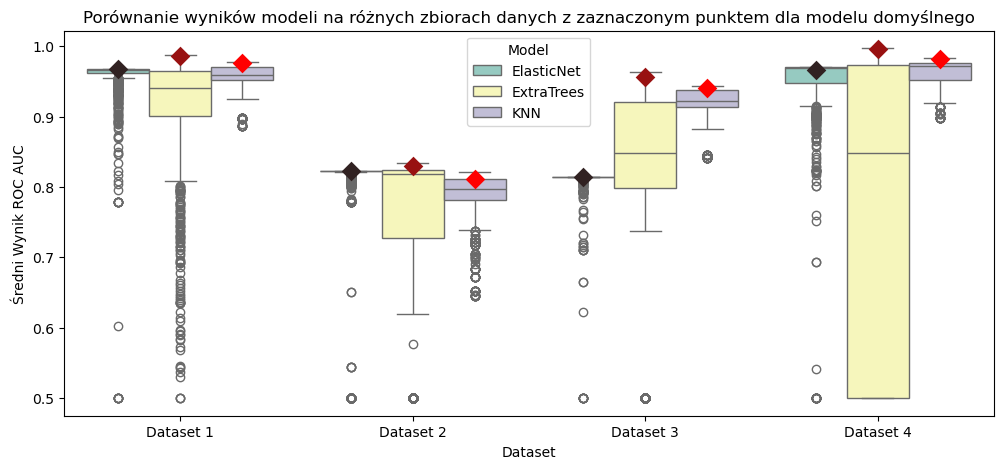

In [62]:
#boxplot z wynikami, oś x: zbiory danych, oś y: średnie wyniki, dla trzech modeli: ElasticNet, ExtraTrees, KNN, dla wszystkich modeli z random search

data = {
    'Dataset 1': {
        'ElasticNet': summary_table_en[f'mean_score_1'].dropna().values,
        'ExtraTrees': summary_table_et[f'mean_score_1'].dropna().values,
        'KNN': summary_table_knn[f'mean_score_1'].dropna().values
    },
    'Dataset 2': {
        'ElasticNet': summary_table_en[f'mean_score_2'].dropna().values,
        'ExtraTrees': summary_table_et[f'mean_score_2'].dropna().values,
        'KNN': summary_table_knn[f'mean_score_2'].dropna().values
    },
    'Dataset 3': {
        'ElasticNet': summary_table_en[f'mean_score_3'].dropna().values,
        'ExtraTrees': summary_table_et[f'mean_score_3'].dropna().values,
        'KNN': summary_table_knn[f'mean_score_3'].dropna().values
    },
    'Dataset 4': {
        'ElasticNet': summary_table_en[f'mean_score_4'].dropna().values,
        'ExtraTrees': summary_table_et[f'mean_score_4'].dropna().values,
        'KNN': summary_table_knn[f'mean_score_4'].dropna().values
    }
}

# Prepare data for plotting
plot_data = []
for dataset, models in data.items():
    for model, scores in models.items():
        for score in scores:
            plot_data.append({'Dataset': dataset, 'Model': model, 'Mean Score': score})

# Add a red point for the default model scores
default_scores = {
    'Dataset 1': {
        'ElasticNet': summary_table_en.iloc[0][f'mean_score_1'],
        'ExtraTrees': summary_table_et.iloc[0][f'mean_score_1'],
        'KNN': summary_table_knn.iloc[0][f'mean_score_1']
    },
    'Dataset 2': {
        'ElasticNet': summary_table_en.iloc[0][f'mean_score_2'],
        'ExtraTrees': summary_table_et.iloc[0][f'mean_score_2'],
        'KNN': summary_table_knn.iloc[0][f'mean_score_2']
    },
    'Dataset 3': {
        'ElasticNet': summary_table_en.iloc[0][f'mean_score_3'],
        'ExtraTrees': summary_table_et.iloc[0][f'mean_score_3'],
        'KNN': summary_table_knn.iloc[0][f'mean_score_3']
    },
    'Dataset 4': {
        'ElasticNet': summary_table_en.iloc[0][f'mean_score_4'],
        'ExtraTrees': summary_table_et.iloc[0][f'mean_score_4'],
        'KNN': summary_table_knn.iloc[0][f'mean_score_4']
    }
}
for dataset, models in default_scores.items():
    for model, score in models.items():
        plot_data.append({'Dataset': dataset, 'Model': model, 'Mean Score': score, 'Default': True})
plot_df = pd.DataFrame(plot_data)

# Plotting
plt.figure(figsize=(12, 5))

# Boxplot (bez zmian)
sns.boxplot(x='Dataset', y='Mean Score', hue='Model', data=plot_df, palette='Set3')

# Wyodrębnij punkty domyślne
default_points = plot_df[plot_df['Default'] == True]

# --- POCZĄTEK POPRAWKI ---
# Zamiast scatterplot, używamy stripplot, który obsługuje 'dodge=True'
sns.stripplot(
    x='Dataset',
    y='Mean Score',
    hue='Model',          # 'hue' jest nadal potrzebne, aby dodge=True wiedziało, JAK rozsunąć punkty
    data=default_points,
    color='red',          # Nadpisuje kolor z 'hue'
    size=10,              # <-- ZMIANA: 'size=10' zamiast 's=100'
    marker='D',
    legend=False,
    dodge=True,           # <-- Działa poprawnie ze stripplot
    ax=plt.gca()          # Dobra praktyka: upewnij się, że rysujesz na tej samej osi co boxplot
)
# --- KONIEC POPRAWKI ---

plt.title('Porównanie wyników modeli na różnych zbiorach danych z zaznaczonym punktem dla modelu domyślnego')
plt.ylabel('Średni Wynik ROC AUC')
plt.legend(title='Model')
plt.show()




## wykresy liniowe wyników w zależności od iteracji

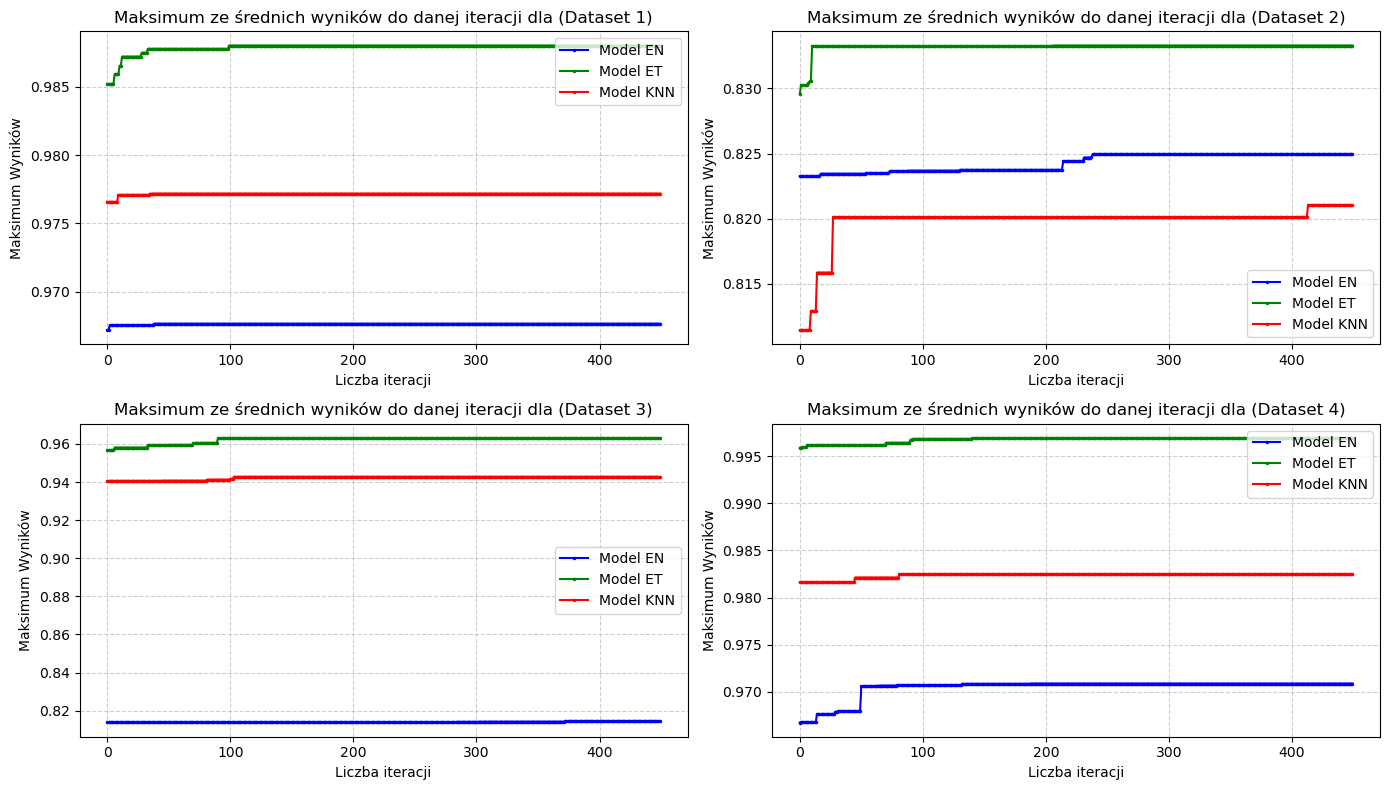

In [60]:
num_rows = 450
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()


for i in range(1, 5):
    
    ax = axes[i-1]
    col_name = f'mean_score_{i}'
    
    # Przetwarzanie danych dla Modelu EN (df1)
    df1 = summary_table_en[[col_name]].head(num_rows).copy()
    df1['cummax'] = df1[col_name].cummax()
    ax.plot(df1.index, df1['cummax'], marker='.', linestyle='-', color='b', label='Model EN', markersize=3)
    
    # Przetwarzanie danych dla Modelu ET (df2)
    df2 = summary_table_et[[col_name]].head(num_rows).copy()
    df2['cummax'] = df2[col_name].cummax()
    ax.plot(df2.index, df2['cummax'], marker='.', linestyle='-', color='g', label='Model ET', markersize=3)
    
    # Przetwarzanie danych dla Modelu KNN (df3)
    df3 = summary_table_knn[[col_name]].head(num_rows).copy()
    df3['cummax'] = df3[col_name].cummax()
    ax.plot(df3.index, df3['cummax'], marker='.', linestyle='-', color='r', label='Model KNN', markersize=3)
    
    # Ustawianie tytułu i etykiet dla każdego pod-wykresu
    ax.set_title(f'Maksimum ze średnich wyników do danej iteracji dla (Dataset {i})')
    ax.set_xlabel('Liczba iteracji')
    ax.set_ylabel('Maksimum Wyników')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    ax.legend()


#fig.suptitle('Wynik w zalezności od liczby iteracji dla 4 zbiorów danych (pierwsze 450 iteracji)', fontsize=20, y=1.03)

# Automatyczne dopasowanie układu, aby etykiety się nie nakładały
plt.tight_layout()

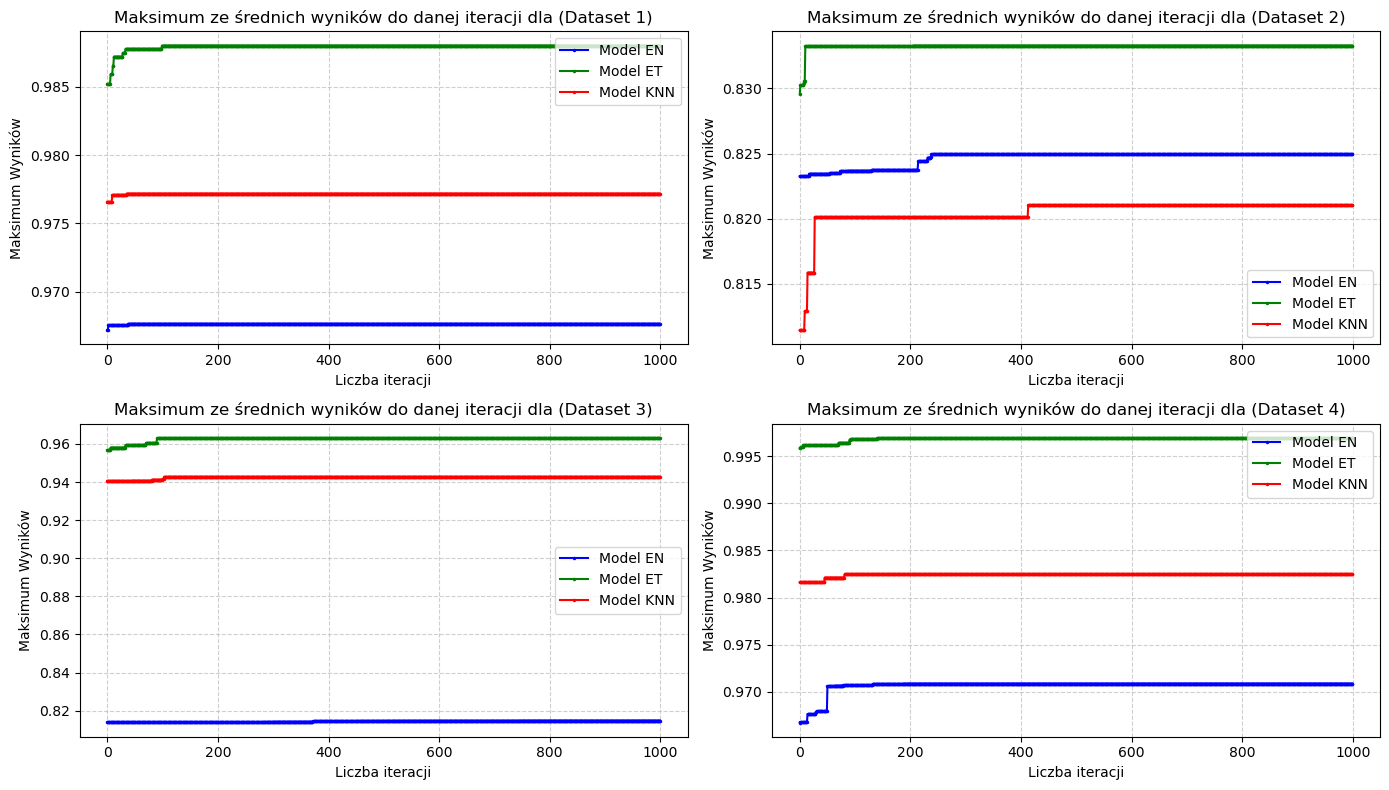

In [59]:
num_rows = 1000
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()


for i in range(1, 5):
    
    ax = axes[i-1]
    col_name = f'mean_score_{i}'
    
    # Przetwarzanie danych dla Modelu EN (df1)
    df1 = summary_table_en[[col_name]].head(num_rows).copy()
    df1['cummax'] = df1[col_name].cummax()
    ax.plot(df1.index, df1['cummax'], marker='.', linestyle='-', color='b', label='Model EN', markersize=3)
    
    # Przetwarzanie danych dla Modelu ET (df2)
    df2 = summary_table_et[[col_name]].head(num_rows).copy()
    df2['cummax'] = df2[col_name].cummax()
    ax.plot(df2.index, df2['cummax'], marker='.', linestyle='-', color='g', label='Model ET', markersize=3)
    
    # Przetwarzanie danych dla Modelu KNN (df3)
    df3 = summary_table_knn[[col_name]].head(num_rows).copy()
    df3['cummax'] = df3[col_name].cummax()
    ax.plot(df3.index, df3['cummax'], marker='.', linestyle='-', color='r', label='Model KNN', markersize=3)
    
    # Ustawianie tytułu i etykiet dla każdego pod-wykresu
    ax.set_title(f'Maksimum ze średnich wyników do danej iteracji dla (Dataset {i})')
    ax.set_xlabel('Liczba iteracji')
    ax.set_ylabel('Maksimum Wyników')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    ax.legend()


#fig.suptitle('Wynik w zalezności od liczby iteracji dla 4 zbiorów danych', fontsize=20, y=1.03)

# Automatyczne dopasowanie układu, aby etykiety się nie nakładały
plt.tight_layout()

## Bayesy

In [34]:
results_en = []
for i in range(4):
    df = pd.read_csv(f"bayes_search_results_{i+1}_en.csv")
    results_en.append(df)

results_et = []
for i in range(4):
    df = pd.read_csv(f"bayes_search_results_{i+1}_et.csv")
    results_et.append(df)

results_knn = []
for i in range(4):
    df = pd.read_csv(f"bayes_search_results_{i+1}_knn.csv")
    results_knn.append(df)

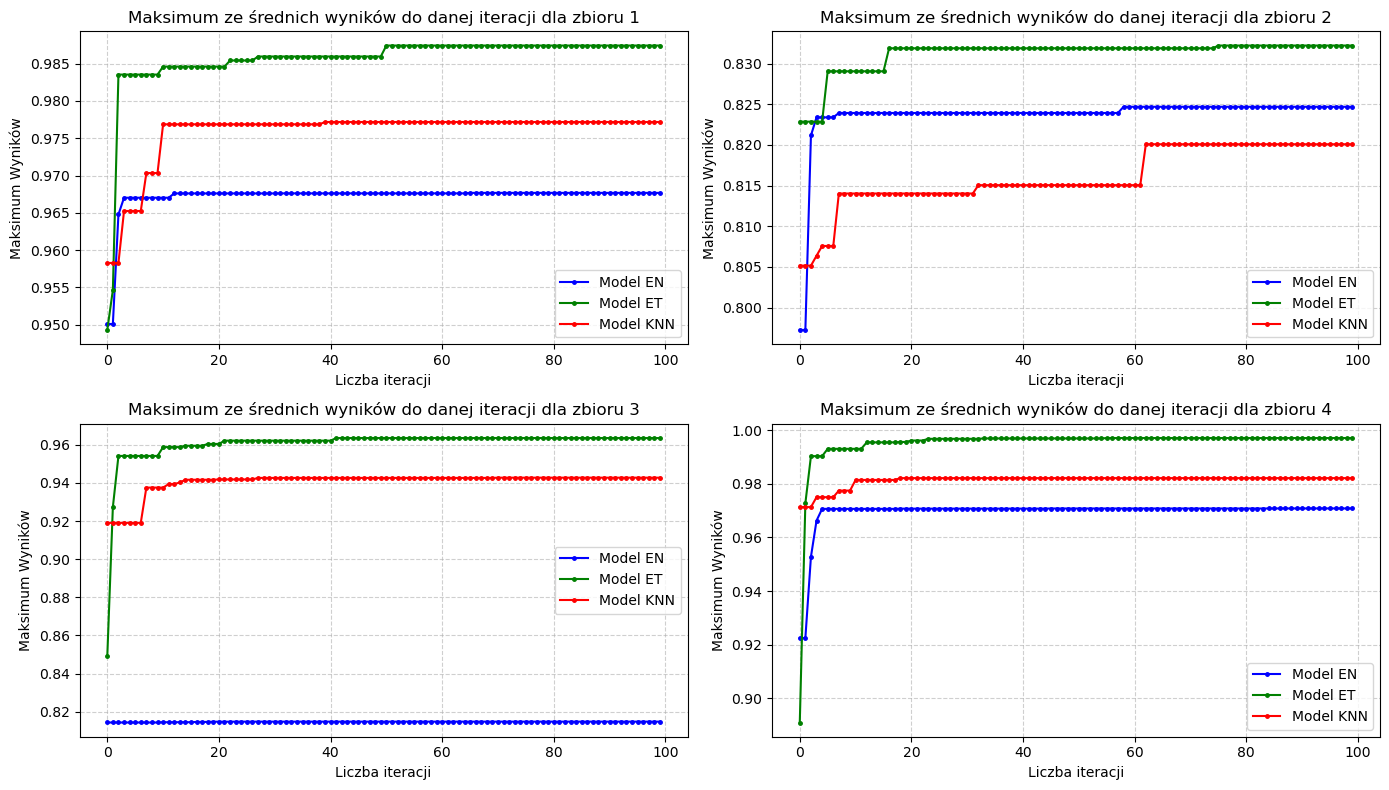

In [58]:
num_rows = 100
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()
col_name = 'mean_test_score'

# wykresy dla wyników optymalizacji bayesowskiej
for i in range(1, 5):
    
    ax = axes[i-1]
    
    # Przetwarzanie danych dla Modelu EN (df1)
    df1 = results_en[i-1][[col_name]].copy()
    df1['cummax'] = df1[col_name].cummax()
    ax.plot(df1.index, df1['cummax'], marker='.', linestyle='-', color='b', label='Model EN', markersize=5)
    
    # Przetwarzanie danych dla Modelu ET (df2)
    df2 = results_et[i-1][[col_name]].copy()
    df2['cummax'] = df2[col_name].cummax()
    ax.plot(df2.index, df2['cummax'], marker='.', linestyle='-', color='g', label='Model ET', markersize=5)
    
    # Przetwarzanie danych dla Modelu KNN (df3)
    df3 = results_knn[i-1][[col_name]].copy()
    df3['cummax'] = df3[col_name].cummax()
    ax.plot(df3.index, df3['cummax'], marker='.', linestyle='-', color='r', label='Model KNN', markersize=5)
    
    # Ustawianie tytułu i etykiet dla każdego pod-wykresu
    ax.set_title(f'Maksimum ze średnich wyników do danej iteracji dla zbioru {i}')
    ax.set_xlabel('Liczba iteracji')
    ax.set_ylabel('Maksimum Wyników')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    ax.legend()

#fig.suptitle('Wynik w zależności od liczby iteracji optymalizacji bayesowskiej dla 4 zbiorów danych', fontsize=20, y=1.03)

plt.tight_layout()